# Example: Dynamical decoupling

There is a standard compilation stage for automatically applying dynamical decoupling (DD) sequences to an instruction schedule,
controlled by the `dd_mode` compiler option. By default the DD stage is disabled.

The `iqm.cpc.compiler.dd` module contains various utility functions the DD stage uses, e.g. for locating specific instructions in a schedule, constructing DD sequences, and replacing select instructions with them. For example, we can find locations of `Wait` instructions on qubit drive channels with a certain minimum duration, and replace them with an arbitrary sequence of `Wait` and `IQPulse` instructions that dynamically decouples the qubit, given that the total duration of the sequence is the same as the duration of the original `Wait`.

In [1]:
import os

from IPython.core.display import HTML
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.result import marginal_distribution

from iqm.cpc.compiler.dd import STANDARD_DD_STRATEGY
from iqm.cpc.interface.compiler import (
    CircuitBoundaryMode,
    CircuitExecutionOptions,
    DDMode,
    HeraldingMode,
    MeasurementMode,
    MoveGateFrameTrackingMode,
    MoveGateValidationMode,
)

from iqm.pulla.pulla import Pulla
from iqm.pulla.utils_qiskit import qiskit_circuits_to_pulla, station_control_result_to_qiskit
from iqm.pulse.playlist.visualisation.base import inspect_playlist
from iqm.qiskit_iqm import IQMProvider
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates

In [2]:
cocos_url = os.environ['PULLA_COCOS_URL']  # or set the URL directly here
station_control_url = os.environ['PULLA_STATION_CONTROL_URL']  # or set the URL directly here

provider = IQMProvider(cocos_url)
backend = provider.get_backend()
p = Pulla(station_control_url=station_control_url)

Let's create and transpile a quantum circuit that prepares a superposition on one qubit, and then executes a long sequence of gates on other qubits while the first qubit is idling and experiencing decoherence. Finally we reverse the superposition and measure the qubits.

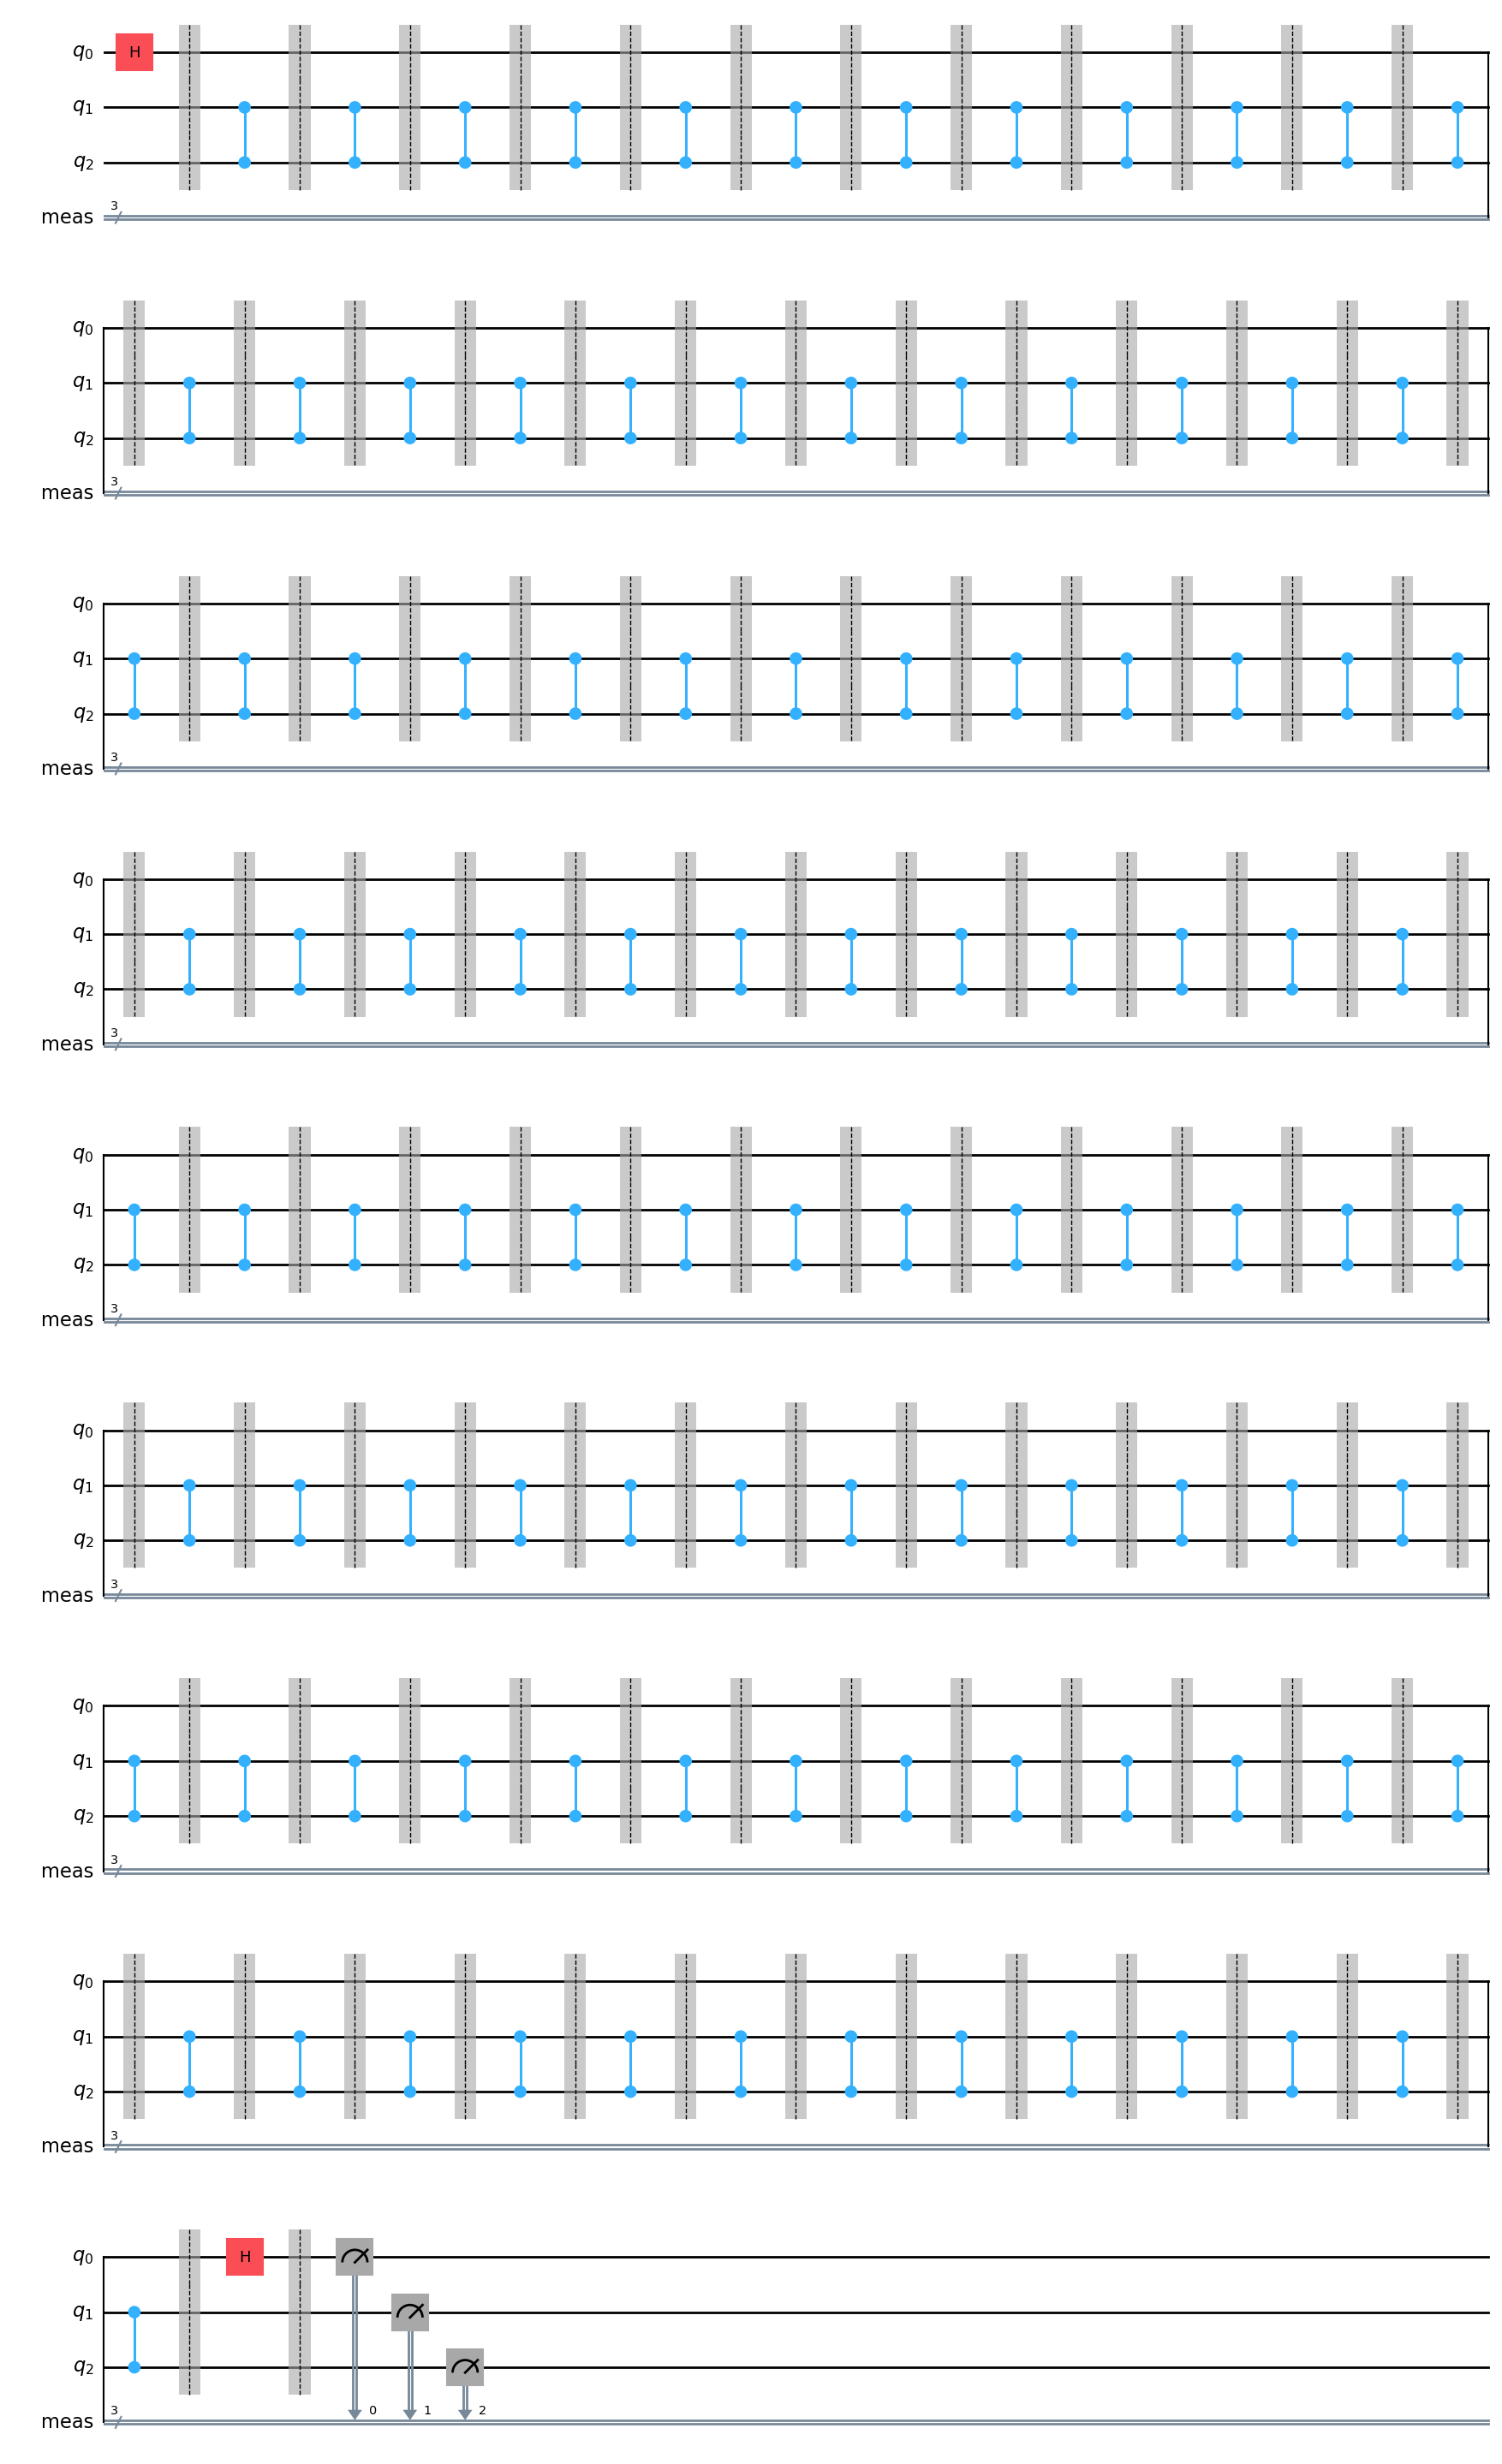

In [3]:
qc = QuantumCircuit(3)
for _ in range(1):
    qc.h(0)
    qc.barrier()
for _ in range(100):
    qc.cz(1, 2)
    qc.barrier()
qc.h(0)
qc.measure_all()
qc.draw(output='mpl')

In [4]:
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
qc_optimized = optimize_single_qubit_gates(qc_transpiled)
c = qiskit_circuits_to_pulla(qc_optimized, qubit_idx_to_name=backend._idx_to_qb)

shots = 10000

Now let us create a pair of Pulla compilers, one with DD and one without.

In [5]:
standard_compiler = p.get_standard_compiler()

custom_compiler = p.get_standard_compiler()
custom_compiler.options = CircuitExecutionOptions(
    measurement_mode=MeasurementMode.ALL,
    heralding_mode=HeraldingMode.NONE,
    dd_mode=DDMode.ENABLED,
    dd_strategy=STANDARD_DD_STRATEGY,
    circuit_boundary_mode=CircuitBoundaryMode.ALL,
    move_gate_frame_tracking=MoveGateFrameTrackingMode.FULL,
    move_gate_validation=MoveGateValidationMode.STRICT,
    active_reset_cycles=None,
)

Compiling the circuit using the non-DD compiler produces a schedule with a long wait on QB1__drive.awg.

In [ ]:
playlist, context = standard_compiler.compile(c)
settings, context = standard_compiler.build_settings(context, shots=shots)
HTML(inspect_playlist(playlist, [0]))

We then execute this schedule and compute the probability of finding QB1 in the |0> state. Ideally this should be one, but due to the decoherence experienced by the superposition state it will be less.

In [7]:
response_without_dd = p.execute(playlist, context, settings, verbose=False)
qiskit_result = station_control_result_to_qiskit(
    response_without_dd, shots=shots, execution_options=standard_compiler.options
)
counts_orig = qiskit_result.get_counts()
print(f"\nQiskit result counts:\n{counts_orig}\n")

prob = marginal_distribution(counts_orig, indices=[0])['0'] / shots
print(f"Probability of finding qubit 0 it the |0> state (original circuit): {prob}")

[06-17 14:53:56;I] Created job in queue with ID: df5e82cd-348d-48fd-8070-ac8198715e79
[06-17 14:53:56;I] Job link: http://varda.qc.iqm.fi/station/jobs/df5e82cd-348d-48fd-8070-ac8198715e79
[06-17 14:53:56;I] Waiting for the job to finish...
[06-17 14:53:57;I] Waiting for job ID: df5e82cd-348d-48fd-8070-ac8198715e79
[06-17 14:54:03;I] Sweep status: ready

Qiskit result counts:
{'001': 4650, '000': 4197, '110': 29, '100': 272, '101': 272, '010': 246, '011': 302, '111': 32}

Probability of finding qubit 0 it the |0> state (original circuit): 0.4744


Compiling the circuit using the DD compiler instead produces a schedule where the long wait on QB1__drive.awg is replaced by a DD sequence.

In [8]:
playlist, context = custom_compiler.compile(c)
settings, context = custom_compiler.build_settings(context, shots=shots)

We execute the DD schedule and again compute the probability of finding QB1 in the |0> state, and will likely see that the probability has gone up, due to the DD sequence partially decoupling the idling QB1 from various decoherence sources and better preserving the superposition state.

In [9]:
response_with_dd = p.execute(playlist, context, settings, verbose=False)
qiskit_result = station_control_result_to_qiskit(
    response_with_dd, shots=shots, execution_options=custom_compiler.options
)
counts_dd = qiskit_result.get_counts()
print(f"\nQiskit result counts:\n{counts_dd}\n")

prob = marginal_distribution(counts_dd, indices=[0])['0'] / shots
print(f"Probability of finding qubit 0 it the |0> state (dynamically decoupled circuit): {prob}")

[06-17 14:54:03;I] Created job in queue with ID: 20c85aff-354d-475f-8ee2-18accc576507
[06-17 14:54:03;I] Job link: http://varda.qc.iqm.fi/station/jobs/20c85aff-354d-475f-8ee2-18accc576507
[06-17 14:54:03;I] Waiting for the job to finish...
[06-17 14:54:04;I] Waiting for job ID: 20c85aff-354d-475f-8ee2-18accc576507
[06-17 14:54:10;I] Sweep status: ready

Qiskit result counts:
{'000': 6401, '001': 2477, '010': 385, '101': 168, '100': 355, '111': 14, '011': 168, '110': 32}

Probability of finding qubit 0 it the |0> state (dynamically decoupled circuit): 0.7173


We can see that the long wait on QB1__drive.awg was indeed replaced by a DD sequence.

In [ ]:
HTML(inspect_playlist(playlist, [0]))